# Notebook: Prompt Classification on Critical Muons
**Critical Muons**: muon events that deposit `<20MeV` in LAr in coincidence with a deposit in Ge within the signal ROI (e.g, 1.8-2.3 MeV).

**Goal**: test our prompt classifier (*cut + RF*) on these events.

In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 45})

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    df["filenumber"] = 0
    for i, file in enumerate(files[1:max_files]):
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        dftmp["filenumber"] = i+1
        df = pd.concat([df, dftmp])
    print("")
    return df

# Load file
The imported file is a csv export of the `SlicedDetection` format.

As in the format, we have information on the event, the deposit, the material and the NPE detected in each slice of the shrouds.

In [3]:
n_inner_slices, n_outer_slices = 12, 20

In [8]:
# Load Ar39
init = time.time()

dirin = os.path.join("..", "..", "Data", "CriticalMuEvents", "Coincidence15Ge_18122020")
fileprefix = "SlicedDetections*csv"
dfmu = load_dataframe_from_files(dirin, fileprefix, 100)

print("[Info] Loaded {} Muons in {:.2f} seconds".format(len(dfmu.groupby(["filenumber", "eventnumber"]).count()), time.time() - init))
dfmu.head()

[Info] Loading 100 files wt prefix:
SlicedDetections*csv
...................................................................................................
[Info] Loaded 9316 Muons in 126.14 seconds


,eventnumber,PID,time,x,y,z,r,material,energydeposition,pedetected,...,OuterSlice12,OuterSlice13,OuterSlice14,OuterSlice15,OuterSlice16,OuterSlice17,OuterSlice18,OuterSlice19,Unnamed: 44,filenumber
0,33,13,27.434000,639.903000,-277.437000,-125.342000,697.457000,ArgonLiquid,1309.713321,7,...,0,0,0,0,0,1,2,0,NaN,0
1,33,13,27.646335,641.847527,-239.674405,-176.556940,685.136533,ArgonLiquid,11714.108340,61,...,1,0,3,0,3,8,12,14,NaN,0
2,33,13,27.697411,642.318107,-230.590987,-188.874830,682.454947,ArgonLiquid,3355.274779,9,...,0,0,0,0,0,1,2,1,NaN,0
3,33,13,27.719992,642.527166,-226.576132,-194.321321,681.306027,ArgonLiquid,1274.436632,10,...,0,0,0,0,1,1,3,3,NaN,0
4,33,13,27.731430,642.633319,-224.542504,-197.079911,680.732634,ArgonLiquid,664.694746,2,...,0,0,0,0,0,0,1,1,NaN,0


In [11]:
# create id to avoid event number overlap
dfmu["id"] = dfmu["filenumber"].astype(str) + dfmu["eventnumber"].astype(str)

In [13]:
dfmu.id.nunique()

9315

# Plot the energy depositions of these events

In [14]:
ge_energy = dfmu[dfmu["material"]=="GermaniumEnriched"].groupby("id").energydeposition.sum()
lar_energy = dfmu[dfmu["material"]=="ArgonLiquid"].groupby("id").energydeposition.sum()

In [38]:
events = pd.DataFrame()
events["id"] = dfmu["id"].unique()
events["energydeposition"] = 0

In [39]:
events = events.join(ge_energy, on="id", how="inner", rsuffix="_ge")
events = events.join(lar_energy, on="id", how="inner", rsuffix="_lar")

**Note**: we consider only events with both deposits in Ge and LAr, for fast join operations

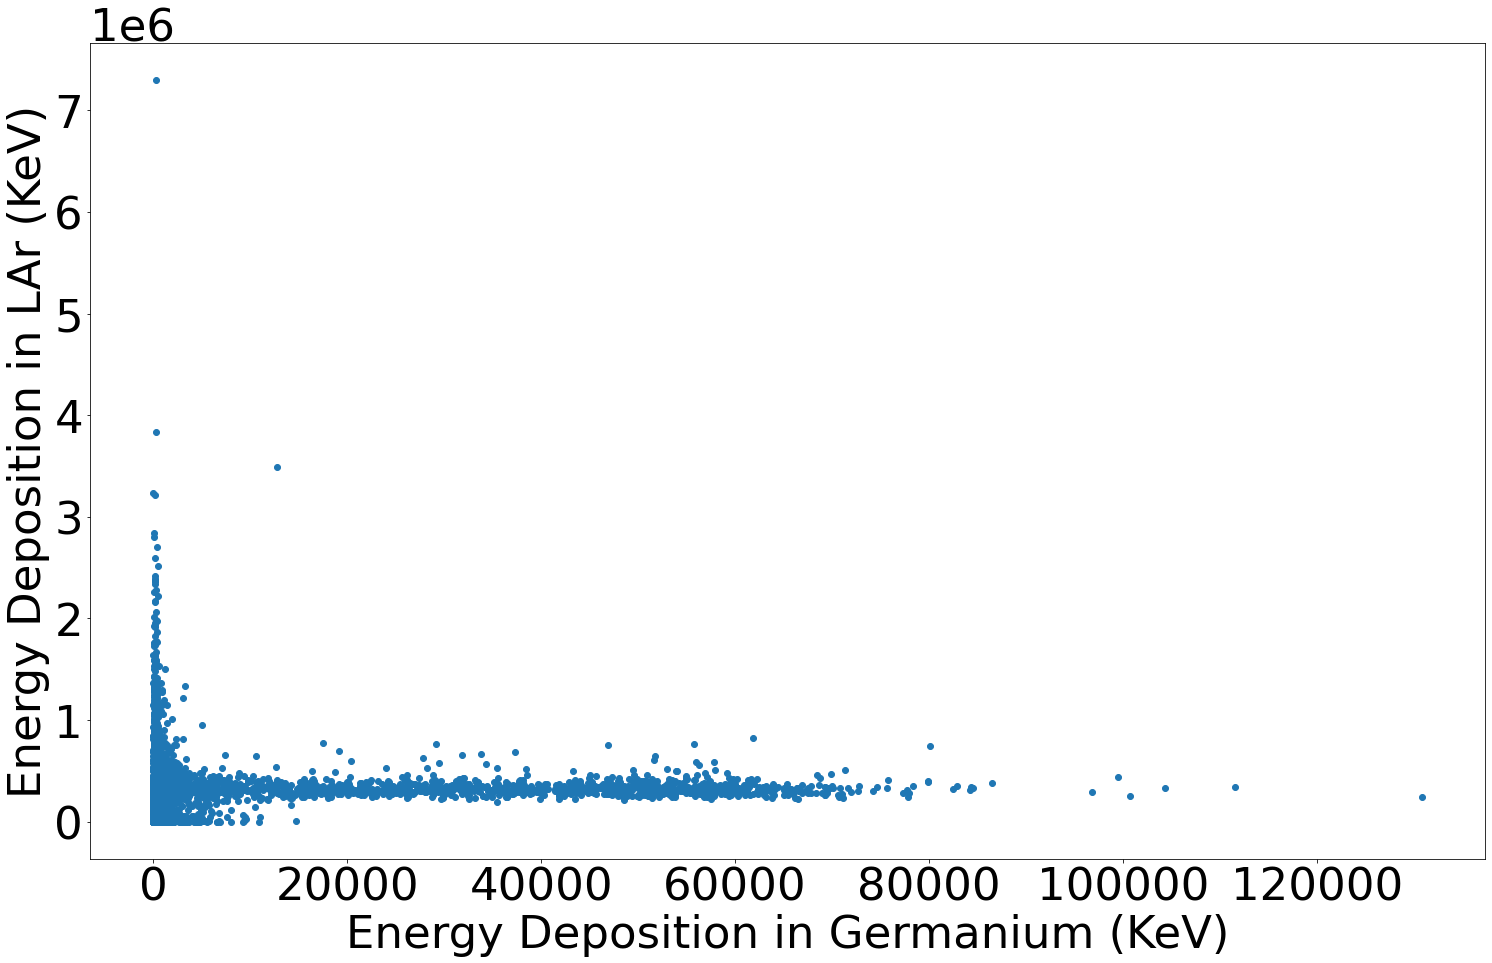

In [41]:
plt.scatter(events.energydeposition_ge, events.energydeposition_lar)
plt.xlabel("Energy Deposition in Germanium (KeV)")
plt.ylabel("Energy Deposition in LAr (KeV)")
plt.show()

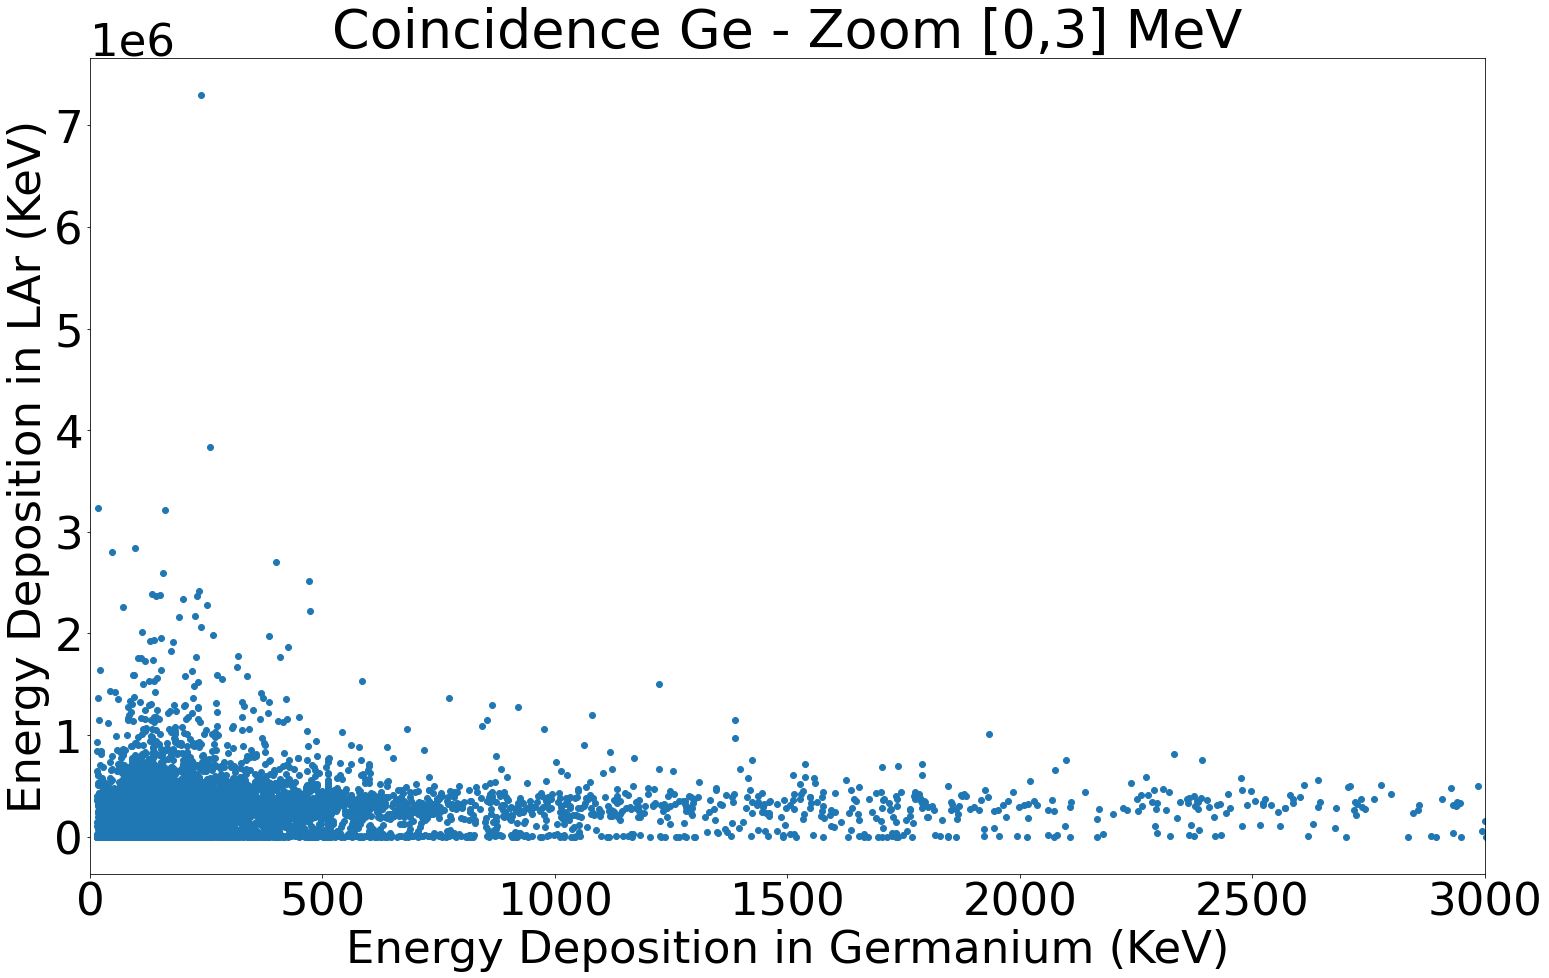

In [44]:
plt.scatter(events.energydeposition_ge, events.energydeposition_lar)
plt.xlabel("Energy Deposition in Germanium (KeV)")
plt.ylabel("Energy Deposition in LAr (KeV)")
plt.title("Coincidence Ge - Zoom [0,3] MeV")
plt.xlim(0, 3000)
plt.show()

# Plot the PE Spectrum of these events

In [47]:
lar_pedet = dfmu.groupby("id").pedetected.sum()
events = events.join(lar_pedet, on="id", how="inner")

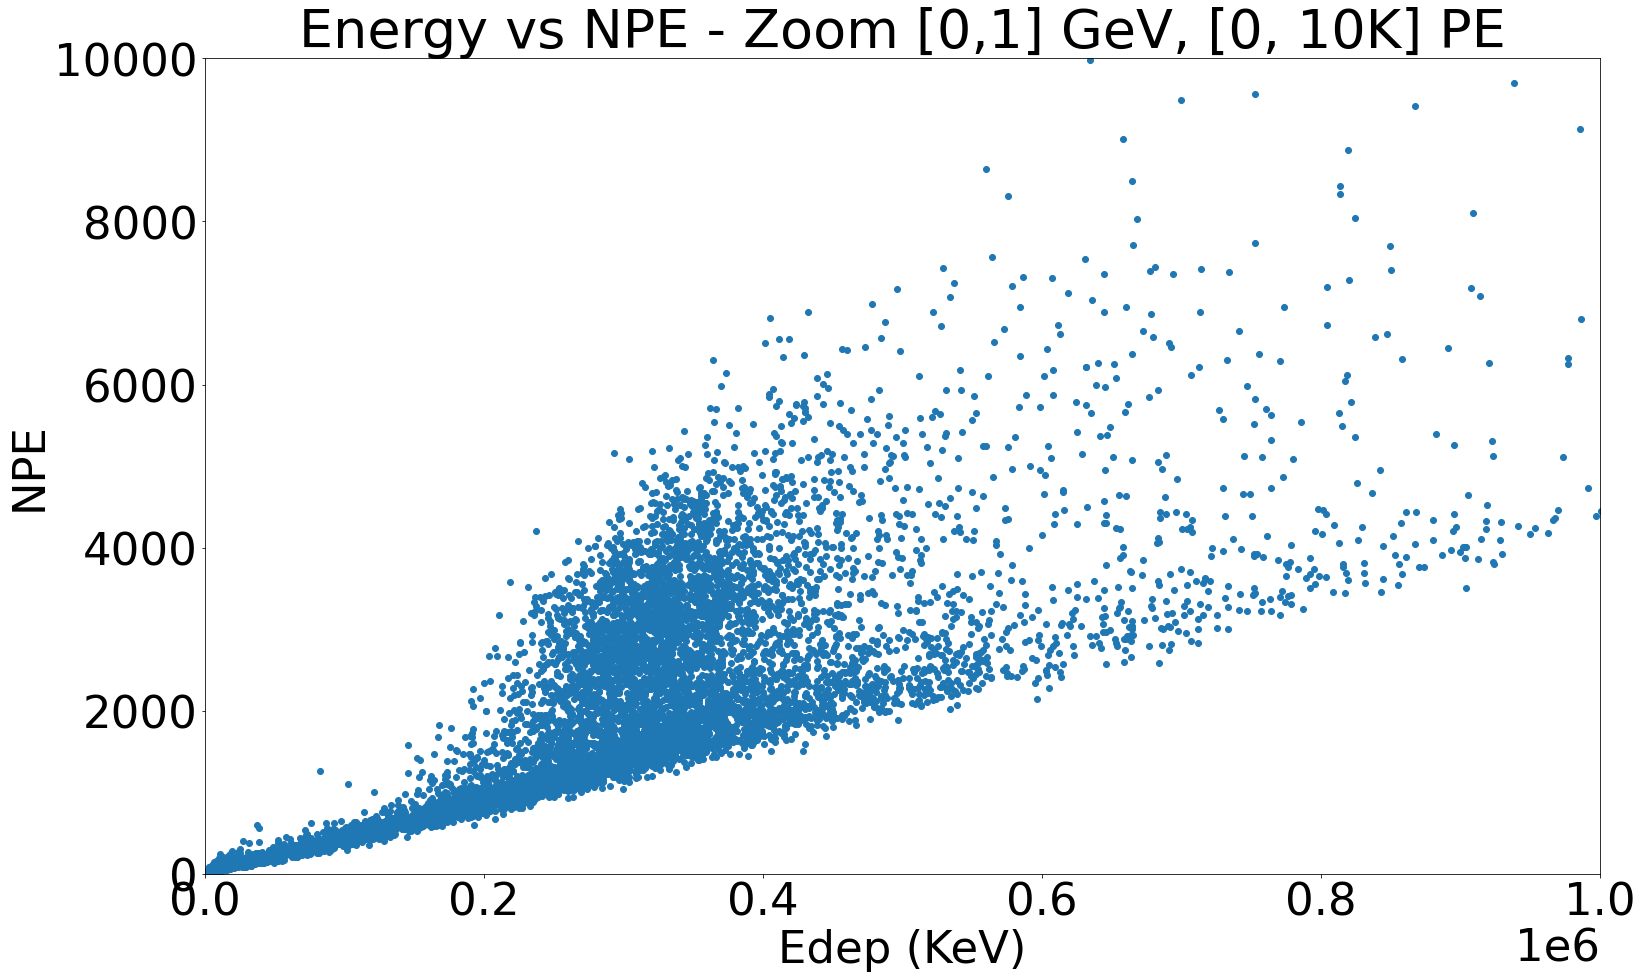

In [52]:
plt.scatter(events.energydeposition_lar, events.pedetected)
plt.xlabel("Edep (KeV)")
plt.ylabel("NPE")
plt.xlim(0, 1000000)
plt.ylim(0, 10000)
plt.title("Energy vs NPE - Zoom [0,1] GeV, [0, 10K] PE")
plt.show()

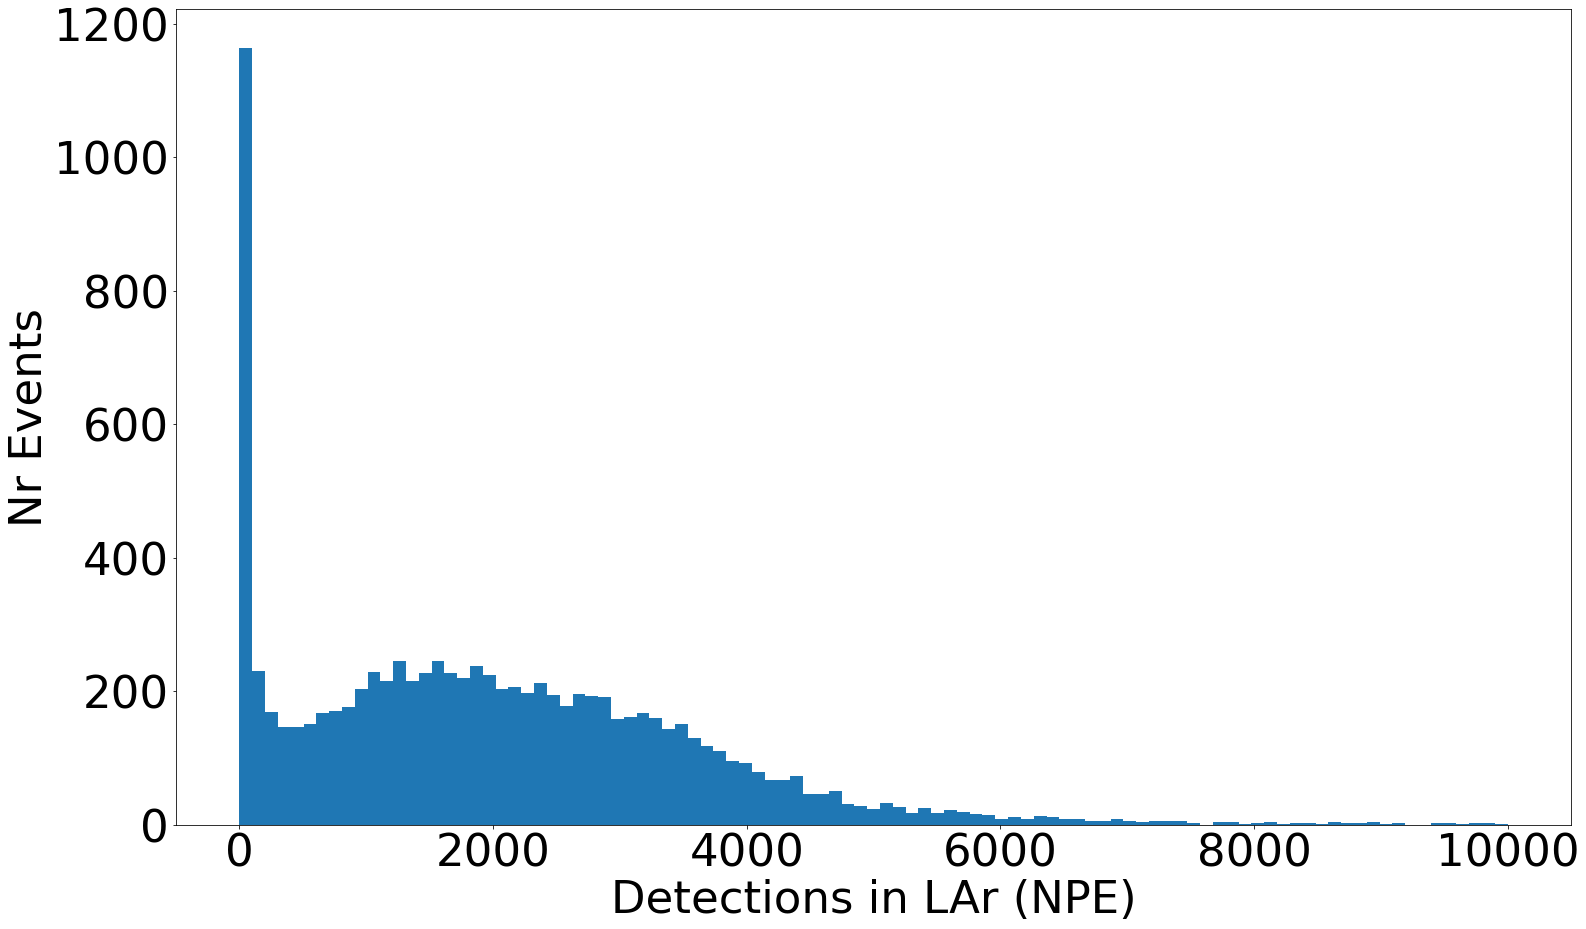

In [56]:
plt.hist(events.pedetected, bins=np.linspace(0, 10000, 100))
plt.xlabel("Detections in LAr (NPE)")
plt.ylabel("Nr Events")
plt.show()

# Compute snapshots
# NOTE: do this for few events, not efficient on 9K events .-.

In [57]:
def get_first_detection_time(event):
    if len(event[event.pedetected>0])>0:
        return event[event.pedetected>0].time.min()
    return False

def get_detections_on_time_window(event, t0, time_window, n_inner_slices=12, n_outer_slices=20):
    inner_detections, outer_detections = np.zeros(n_inner_slices, dtype=int), np.zeros(n_outer_slices, dtype=int)
    event = event[(event.time>=t0) & (event.time<=t0+time_window)]
    event = event.groupby("id").sum().reset_index()
    #return event.iloc[:, 3:3+n_inner_slices], event.iloc[:, 3+inner_detections:3+n_inner_slices+n_outer_slices]
    return event

In [63]:
event_t0s = get_first_detection_time(dfmu)

In [66]:
import time
snapshots = pd.DataFrame()
init = time.time()
for i, e in enumerate(dfmu.id.unique()):
    if i % 1000 == 0:
        print(f"Processing the {i+1} event. Time: {time.time()-init}")
    event = dfmu[dfmu.id==e]
    t0 = get_first_detection_time(event)
    if t0:
        event = get_detections_on_time_window(event, t0, 10000)
        snapshots = pd.concat([snapshots, event])
    else:
        pass

Processing the 1 event. Time: 0.11750602722167969
Processing the 1001 event. Time: 137.81080865859985
Processing the 2001 event. Time: 286.70036125183105
Processing the 3001 event. Time: 425.309611082077
Processing the 4001 event. Time: 564.8271098136902
Processing the 5001 event. Time: 701.5744545459747
Processing the 6001 event. Time: 838.1541454792023
Processing the 7001 event. Time: 974.6949777603149
Processing the 8001 event. Time: 1111.8634197711945
Processing the 9001 event. Time: 1278.2412633895874


In [82]:
len(snapshots)

9183

In [75]:
snapshots = snapshots.reset_index()
cols = ["id"] + snapshots.columns[12:].to_list()
snapshots = snapshots[cols]

In [76]:
print(f"[Info] Produced Snapshots (NPE>0 + Time<10us): {len(snapshots)}")

[Info] Produced Snapshots (NPE>0 + Time<10us): 9183


# compute features

In [77]:
# Create Features
def pe_detected(row):
    return np.sum(row.to_numpy())

def nr_active_slices(row):
    return np.nonzero(row.to_numpy())[0].shape[0]

def mean_npe(row):
    return np.mean(row.to_numpy())

def mean_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.mean(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def std_npe(row):
    return np.std(row.to_numpy())

def std_npe_active(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return np.std(rownp[rownonzero]) if rownonzero.shape[0]>0 else -1

def range_detections(row):
    rownp = row.to_numpy()
    rownonzero = np.nonzero(rownp)[0]
    return rownonzero[-1] - rownonzero[0] + 1 if rownonzero.shape[0]>0 else -1

def spatial_var(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.var(ids) if ids.shape[0]>0 else -1

def spatial_std(row):
    rownp = row.to_numpy()
    ids = np.repeat(np.argwhere(rownp>0), rownp[rownp>0])
    return np.std(ids) if ids.shape[0]>0 else -1

In [79]:
snapshots.head()

,id,InnerSlice8,InnerSlice9,InnerSlice10,InnerSlice11,OuterSlice0,OuterSlice1,OuterSlice2,OuterSlice3,OuterSlice4,...,MeanNPEActive_inner,StdNPEActive_inner,SpatialRange_inner,SpatialVar_inner,SpatialStd_inner,PEDetected_outer,NActiveSlices_outer,MeanNPEActive_outer,StdNPEActive_outer,SpatialRange_outer
0,033,0,0,6,6,99,72,45,30,5,...,26.900000,32.840371,10,2.045356,1.430159,577.785727,13,44.445056,70.627171,16
1,01250,197,211,72,30,25,10,7,4,3,...,47.833333,72.402617,12,4.413396,2.100808,3705.649346,18,205.869408,209.947719,20
2,03618,0,0,0,0,0,0,0,0,0,...,-1.000000,-1.000000,-1,-1.000000,-1.000000,30.000000,11,2.727273,4.091919,16
3,03727,37,36,38,14,36,6,3,3,1,...,15.416667,15.445918,12,6.939781,2.634346,3343.802366,18,185.766798,182.464753,20
4,03839,82,82,78,85,9,24,39,36,48,...,127.333333,161.815396,12,14.052944,3.748726,2359.201672,18,131.066760,346.752919,20


In [78]:
# features for rforest
my_features = ["PEDetected_outer", "NActiveSlices_outer", "MeanNPEActive_outer", "SpatialVar_outer", "SpatialRange_outer", 
               "PEDetected_inner", "NActiveSlices_inner", "MeanNPEActive_inner", "SpatialVar_inner", "SpatialRange_inner",
               "PEDetected_tot", "NActiveSlices_tot", "MeanNPEActive_tot"]

init = time.time()
featmu = snapshots
featmu["PEDetected_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: pe_detected(row), axis=1)
featmu["NActiveSlices_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: nr_active_slices(row), axis=1)
featmu["MeanNPEActive_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: mean_npe_active(row), axis=1)
featmu["StdNPEActive_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: std_npe_active(row), axis=1)
featmu["SpatialRange_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: range_detections(row), axis=1)
featmu["SpatialVar_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: spatial_var(row), axis=1)
featmu["SpatialStd_inner"] = snapshots.iloc[:, 1:1+n_inner_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Inner features: {:.3f} sec".format(time.time() - init))
init = time.time()
featmu["PEDetected_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: pe_detected(row), axis=1)
featmu["NActiveSlices_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: nr_active_slices(row), axis=1)
featmu["MeanNPEActive_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: mean_npe_active(row), axis=1)
featmu["StdNPEActive_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: std_npe_active(row), axis=1)
featmu["SpatialRange_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: range_detections(row), axis=1)
featmu["SpatialVar_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: spatial_var(row), axis=1)
featmu["SpatialStd_outer"] = snapshots.iloc[:, 1+n_inner_slices:1+n_inner_slices+n_outer_slices].apply(lambda row: spatial_std(row), axis=1)
print("Compute Mu Outer features: {:.3f} sec".format(time.time() - init))
init = time.time()
featmu["PEDetected_tot"] = featmu["PEDetected_inner"] + featmu["PEDetected_outer"]
featmu["NActiveSlices_tot"] = featmu["NActiveSlices_inner"] + featmu["NActiveSlices_outer"]
featmu["MeanNPEActive_tot"] = featmu["PEDetected_tot"] / featmu["NActiveSlices_tot"]
featmu = featmu.fillna(-1)
print("Compute combined features: {:.3f} sec".format(time.time() - init))

Compute Mu Inner features: 2.103 sec


TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

In [81]:
snapshots.columns

Index(['id', 'InnerSlice8', 'InnerSlice9', 'InnerSlice10', 'InnerSlice11',
       'OuterSlice0', 'OuterSlice1', 'OuterSlice2', 'OuterSlice3',
       'OuterSlice4', 'OuterSlice5', 'OuterSlice6', 'OuterSlice7',
       'OuterSlice8', 'OuterSlice9', 'OuterSlice10', 'OuterSlice11',
       'OuterSlice12', 'OuterSlice13', 'OuterSlice14', 'OuterSlice15',
       'OuterSlice16', 'OuterSlice17', 'OuterSlice18', 'OuterSlice19',
       'Unnamed: 44', 'filenumber', 'PEDetected_inner', 'NActiveSlices_inner',
       'MeanNPEActive_inner', 'StdNPEActive_inner', 'SpatialRange_inner',
       'SpatialVar_inner', 'SpatialStd_inner', 'PEDetected_outer',
       'NActiveSlices_outer', 'MeanNPEActive_outer', 'StdNPEActive_outer',
       'SpatialRange_outer'],
      dtype='object')

# load model

In [18]:
from joblib import load

init = time.time()
rf = load("/home/luigi/Development/ML4NP/ML4GeneralMuons/bonsai_dtrees/rf_10est_5depth.joblib")
print("[Info] Loaded model in {:.2f} seconds".format(time.time() - init))

[Info] Loaded model in 0.97 seconds


# predict

In [19]:
data = featmu
data["y"] = 1
X_rf, y_rf = data.loc[:, my_features], data.loc[:, "y"]
X_rf = np.array(X_rf)
y_rf = np.array(y_rf)

init = time.time()
data["y_rf_pred"] = rf.predict_proba(X_rf)[:, 1]
data["cut_4nas"] = np.where(data.NActiveSlices_outer>=4, 1, 0)
data["cut_60pe"] = np.where(data.PEDetected_tot>60, 1, 0)
print("[Info] RForest predict in {:.3f} seconds".format(time.time() - init))

[Info] RForest predict in 0.004 seconds


In [20]:
data["y_combo"] = np.where(((data.cut_60pe>.5) | ((data.cut_4nas>.5) & (data.y_rf_pred>.5))), 1, 0)

In [21]:
print("True Positive: {}".format(len(data[data.y_combo==1])))
print("False Negative: {}".format(len(data[data.y_combo==0])))

True Positive: 20
False Negative: 9


In [22]:
data[(data.y_combo==0) & (data.cut_4nas<.5)].PEDetected_tot

0     8
9     2
11    2
12    8
18    1
Name: PEDetected_tot, dtype: int64

# Focus: muons with Ge deposit in 1 crystal
I collected a list of `eventnumber` that present the Ge deposition in a **single** crystal.

In this section, I will focus on them.

In [29]:
events1ge = [5922, 14758, 42270, 49232, 50750, 68829, 71269, 79041, 79108, 79512, 82977, 93159]

In [43]:
data[data.eventnumber.isin(events1ge)][["eventnumber", "PEDetected_tot", "NActiveSlices_outer", "cut_4nas", "y_rf_pred", "y_combo"]].sort_values(["cut_4nas", "y_combo"])

,eventnumber,PEDetected_tot,NActiveSlices_outer,cut_4nas,y_rf_pred,y_combo
0,49232,8,3,0,0.614038,0
11,42270,2,2,0,0.235413,0
12,50750,8,3,0,0.024056,0
18,68829,1,1,0,0.265152,0
19,71269,8,4,1,0.057010,0
2,14758,82,11,1,0.953653,1
15,5922,17,6,1,0.981980,1
23,82977,26,10,1,0.998078,1
26,79512,23,5,1,0.592837,1
28,93159,9,4,1,0.792178,1


**Observations:**
1. 2 of them have 0 PE detected (undetected). In fact, we have 10 snapshots instead of 12 events.
1. 4 of them have <4 outer slices, then killed by the preliminary cut.
1. 1 of them is misclassified, it has 8 PE detected.
1. 5 of them are correctly classified as muons.